- 保监会 相关度判定

# 基本设定

In [1]:
import os
import time
import sys
import os
import re
import random
import time
import binascii
from bisect import bisect_right
from heapq import heappop, heappush
from gensim import corpora, models, similarities

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import pre_cor
from datasketch import MinHash

D:\software\conda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.292 seconds.
Prefix dict has been built succesfully.


In [2]:
def fig_heatmap(data):
    fig, ax = plt.subplots(figsize=(22, 15))
    cmap = sns.diverging_palette(220, 20, n=20)
    sns.heatmap(data, cmap = cmap,
                annot = True, annot_kws={'size':8, 'weight':'bold', 'color':'blue'}, 
                cbar = True, cbar_kws ={'orientation':'vertical',
                                        'pad':0.005, 'fraction':0.45}, 
                vmax = 1, vmin = -1, linewidths=.5, fmt="0.2f")
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)

# 导入数据

In [3]:
data = pd.read_excel('data/similarity_select.xlsx')
data.head()

,id,content,title,author
0,1,来源：人民币交易与研究\n人民银行会同银监会、证监会、保监会、外汇局等部门于11月17 日发...,10银行联名上书:资管新规可能引发系统性金融风险,网易
1,2,来源：人民币交易与研究\n人民银行会同银监会、证监会、保监会、外汇局等部门于11月17 日发...,10银行联名上书:资管新规可能引发系统性金融风险,网易
2,3,新华社北京11月28日电（记者罗沙）最高人民法院、公安部、司法部、保监会28日联合召开视...,14省市开展交通事故纠纷“网上数据一体化处理”试点,新浪新闻
3,11,"11月24日,中国保监会官方网站公布了2017年保险公司服务评价评级结果,在参评的59家人身...",新华保险再次荣获保监会服务评价AA 评级---三湘都市报数字报刊,三湘都市报
4,12,"11月24日,保监会官方网站公布了2017年保险公司服务评价评级结果,在参评的59家人身险公...",新华保险再次荣获保监会服务评价AA评级,新浪


# 预处理数据

In [4]:
data_content = data['content'].tolist()
data_list = pre_cor.handle_contents(data_content) # 数据结构：['word word']
len(data_list)

25

# minhash
- minhash包的时间太长，完全不能接受
- 只能自编代码实现

## 简单案例
- 案例的大致步骤为：
> - MinHash初始化状态，需要预先设定MinHash()初始化
> - 内容哈希化，内容m1.update哈希化
> - jaccard距离，float(len(s1.intersection(s2)))/float(len(s1.union(s2)))用集合的方式求距离

In [5]:
data1 = data_list[0]
data2 = data_list[1]

m1, m2 = MinHash(), MinHash()
for d in data1:
    m1.update(d.encode('utf8'))
for d in data2:
    m2.update(d.encode('utf8'))
print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m2))

s1 = set(data1)
s2 = set(data2)
actual_jaccard = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
print("Actual Jaccard for data1 and data2 is", actual_jaccard)

Estimated Jaccard for data1 and data2 is 1.0
Actual Jaccard for data1 and data2 is 1.0


## 相似度计算 Jaccard

In [34]:
doc_simi_estimated = []
doc_simi_actual = []

num_perm=128

for i, value in enumerate(data_list):
    doc_simi_est = []
    doc_simi_act = []
    for j, value in enumerate(data_list):
        data_1 = data_list[i].split(' ')
        data_2 = data_list[j].split(' ')
        
        m1, m2 = MinHash(num_perm=num_perm), MinHash(num_perm=num_perm)
        for d in data_1: 
            if len(d) >0:
                m1.update(d.encode('utf8'))
        for d in data_2: 
            if len(d) >0:
                m2.update(d.encode('utf8'))

        s1 = set(data_1)
        s2 = set(data_2)
        estimated_simi = m1.jaccard(m2)
        actual_simi = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
        
        doc_simi_est.append(estimated_simi) 
        doc_simi_act.append(actual_simi)

    doc_simi_estimated.append(doc_simi_est) 
    doc_simi_actual.append(doc_simi_act)            

In [35]:
col_ind = data['id'].tolist()
doc_simi_estimated = pd.DataFrame(doc_simi_estimated, index = col_ind, columns = col_ind)
doc_simi_estimated.head()

,1,2,3,11,12,13,21,22,31,32,...,61,62,71,72,73,74,81,82,83,84
1,1.000000,1.000000,0.023438,0.000000,0.000000,0.000000,0.125000,0.140625,0.093750,0.101562,...,0.062500,0.054688,0.000000,0.000000,0.007812,0.000000,0.007812,0.007812,0.007812,0.007812
2,1.000000,1.000000,0.023438,0.000000,0.000000,0.000000,0.125000,0.140625,0.093750,0.101562,...,0.062500,0.054688,0.000000,0.000000,0.007812,0.000000,0.007812,0.007812,0.007812,0.007812
3,0.023438,0.023438,1.000000,0.007812,0.023438,0.007812,0.062500,0.054688,0.023438,0.023438,...,0.046875,0.039062,0.023438,0.007812,0.023438,0.007812,0.015625,0.023438,0.023438,0.007812
11,0.000000,0.000000,0.007812,1.000000,0.875000,0.726562,0.000000,0.023438,0.031250,0.031250,...,0.023438,0.023438,0.757812,1.000000,0.789062,0.859375,0.039062,0.031250,0.031250,0.000000
12,0.000000,0.000000,0.023438,0.875000,1.000000,0.648438,0.015625,0.031250,0.046875,0.046875,...,0.023438,0.023438,0.820312,0.875000,0.820312,0.757812,0.039062,0.031250,0.031250,0.000000


In [36]:
col_ind = data['id'].tolist()
doc_simi_actual = pd.DataFrame(doc_simi_actual, index = col_ind, columns = col_ind)
doc_simi_actual.head()

,1,2,3,11,12,13,21,22,31,32,...,61,62,71,72,73,74,81,82,83,84
1,1.000000,1.000000,0.042639,0.009557,0.011304,0.008666,0.094625,0.125514,0.067610,0.070423,...,0.055732,0.055200,0.009574,0.009557,0.009549,0.008703,0.006076,0.006944,0.006944,0.006055
2,1.000000,1.000000,0.042639,0.009557,0.011304,0.008666,0.094625,0.125514,0.067610,0.070423,...,0.055732,0.055200,0.009574,0.009557,0.009549,0.008703,0.006076,0.006944,0.006944,0.006055
3,0.042639,0.042639,1.000000,0.027933,0.033520,0.021978,0.051685,0.059105,0.043956,0.045576,...,0.045045,0.039634,0.028249,0.027933,0.027778,0.022599,0.022599,0.028249,0.028249,0.010929
11,0.009557,0.009557,0.027933,1.000000,0.888889,0.733333,0.021407,0.025194,0.046809,0.044898,...,0.038835,0.040201,0.777778,1.000000,0.821429,0.880000,0.093023,0.090909,0.090909,0.020000
12,0.011304,0.011304,0.033520,0.888889,1.000000,0.656250,0.027607,0.027132,0.055556,0.053279,...,0.033654,0.034826,0.814815,0.888889,0.793103,0.777778,0.090909,0.088889,0.088889,0.019608


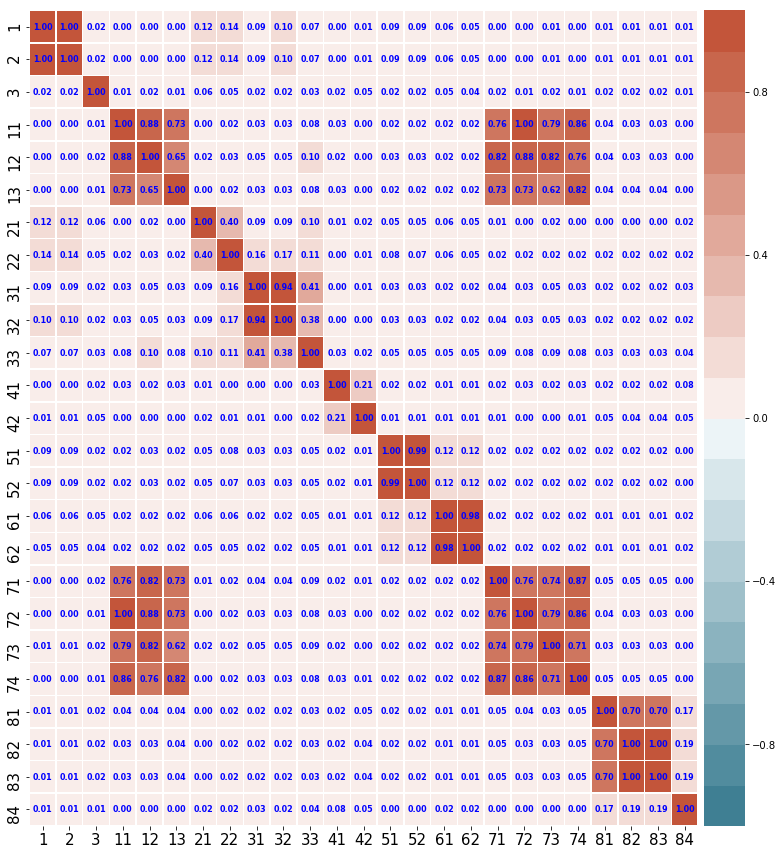

In [37]:
fig_heatmap(doc_simi_estimated)

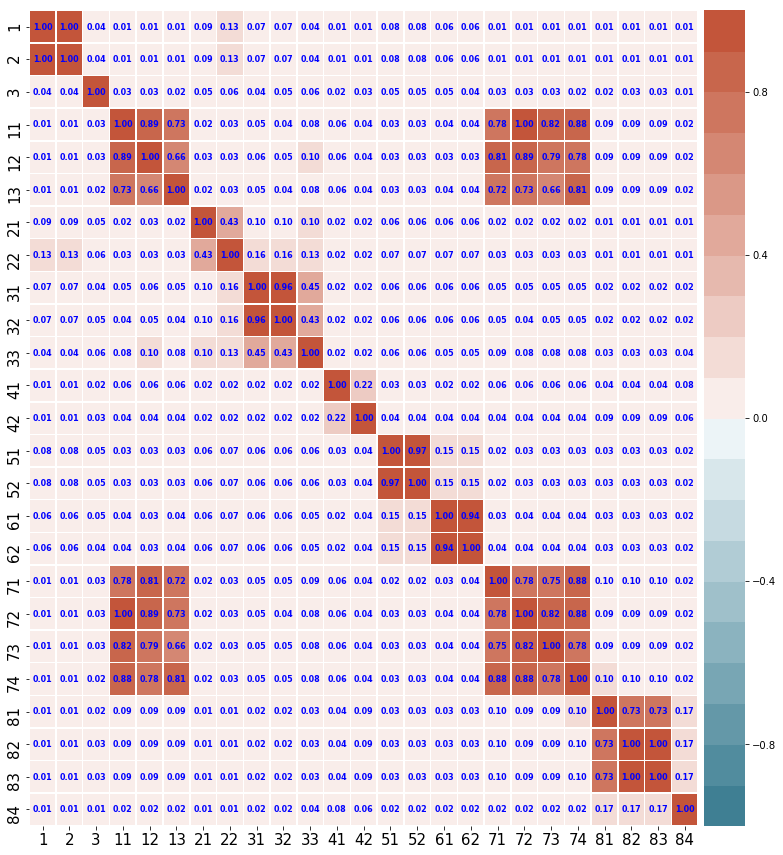

In [38]:
fig_heatmap(doc_simi_actual)

# simhash

In [24]:
import re
from simhash import Simhash

def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

print('%x'%Simhash(get_features('How are you? I am fine. Thanks.')).value)
print('%x'% Simhash(get_features('How are u? I am fine.     Thanks.')).value)
print('%x'% Simhash(get_features('How r you?I    am fine. Thanks.')).value)

4d4da690b5a57e47
69deac90b5a15eeb
4f08a4f4b5a13a4b


In [41]:
import re
from simhash import Simhash, SimhashIndex
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

data = {
    1: u'How are you? I Am fine. blar blar blar blar blar Thanks.',
    2: u'How are you i am fine. blar blar blar blar blar than',
    3: u'This is simhash test.',
}
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k=3)

print(index.bucket_size())

s1 = Simhash(get_features(u'How are you i am fine. blar blar blar blar blar thank'))
print(index.get_near_dups(s1))

index.add('4', s1)
print(index.get_near_dups(s1))

11
['1']
['1', '4']


In [25]:
print(Simhash('aa').distance(Simhash('bb')))
print( Simhash('aa').distance(Simhash('aa')))

31
0


In [44]:
help(Simhash.distance)

Help on function distance in module simhash:

distance(self, another)



In [ ]:
doc_sim = []

num_perm=128

for i, value in enumerate(data_list):
    doc_simi_est = []
    doc_simi_act = []
    for j, value in enumerate(data_list):
        data_1 = data_list[i].split(' ')
        data_2 = data_list[j].split(' ')
        
        m1, m2 = MinHash(num_perm=num_perm), MinHash(num_perm=num_perm)
        for d in data_1: 
            if len(d) >0:
                m1.update(d.encode('utf8'))
        for d in data_2: 
            if len(d) >0:
                m2.update(d.encode('utf8'))

        s1 = set(data_1)
        s2 = set(data_2)
        estimated_simi = m1.jaccard(m2)
        actual_simi = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
        
        doc_simi_est.append(estimated_simi) 
        doc_simi_act.append(actual_simi)

    doc_simi_estimated.append(doc_simi_est) 
    doc_simi_actual.append(doc_simi_act)            

# python code

In [11]:
# 随机哈希函数个数
numHashes = 10 

# 文本代号
docNames = data['id'].tolist()

# 文件数量
numDocs = len(data_list) #100  
numDocs

25

## Shingling articles

In [12]:
# The current shingle ID value to assign to the next new shingle we 
# encounter. When a shingle gets added to the dictionary, we'll increment this
# value.
curShingleID = 0

# 文本shingle后集合
docsAsShingleSets = {}

# 
totalShingles = 0

t0 = time.time()
for i in range(0, numDocs):
    docID = docNames[i]
    words = data_list[i]
    print(i, ' -- ', len(words))
    
    shinglesInDoc = set()
    
    for index in range(0, len(words) - 2): # len(words) - 2
        # Construct the shingle text by combining three words together.
        # 连续三个word合并成shingle
        shingle = words[index] + " " + words[index + 1] + " " + words[index + 2]   
#         shingle = words[index]
        
        # Hash the shingle to a 32-bit integer.
        crc = binascii.crc32(shingle.encode()) & 0xffffffff  
        shinglesInDoc.add(crc)
        
    docsAsShingleSets[docID] = shinglesInDoc
    
    # Count the number of shingles across all documents.
    totalShingles = totalShingles + (len(words) - 2)    
#     totalShingles = totalShingles
    
print('\nShingling ' + str(numDocs) + ' docs took %.3f sec.' % (time.time() - t0))    

0  --  14459
1  --  14459
2  --  786
3  --  94
4  --  94
5  --  92
6  --  1575
7  --  2561
8  --  1188
9  --  1250
10  --  482
11  --  108
12  --  95
13  --  1363
14  --  1396
15  --  1072
16  --  1066
17  --  74
18  --  94
19  --  95
20  --  79
21  --  99
22  --  95
23  --  95
24  --  94

Shingling 25 docs took 0.063 sec.


In [13]:
totalShingles

42815

## Define Triangle Matrices

In [14]:
def getTriangleIndex(i, j):
    '''
        # Define a function to map a 2D matrix coordinate into a 1D index.
    '''
    # If i == j that's an error.
    if i == j:
        sys.stderr.write("Can't access triangle matrix with i == j")
        sys.exit(1)
    # If j < i just swap the values.
    if j < i:
        temp = i
        i = j
        j = temp
  
    # Calculate the index within the triangular array.
    k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
  
    return k

In [15]:
# Calculate the number of elements needed in our triangle matrix
numElems = int(numDocs * (numDocs - 1) / 2)

# Initialize two empty lists to store the similarity values. 
# 'JSim' will be for the actual Jaccard Similarity values. 
# 'estJSim' will be for the estimated Jaccard Similarities found by comparing
# the MinHash signatures.
JSim = [0 for x in range(numElems)]
estJSim = [0 for x in range(numElems)]

In [16]:
print(estJSim)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Generate MinHash Signatures

In [17]:
# Record the maximum shingle ID that we assigned.
maxShingleID = 2**32-1

# We need the next largest prime number above 'maxShingleID'.
# 比maxShingleID稍大一点，用于求余
nextPrime = 4294967311


In [18]:
def pickRandomCoeffs(k):
    '''
    # Our random hash function will take the form of:
    #   h(x) = (a*x + b) % c
    # Where 'x' is the input value, 'a' and 'b' are random coefficients, and 'c' is
    # a prime number just greater than maxShingleID.

    # Generate a list of 'k' random coefficients for the random hash functions,
    # while ensuring that the same value does not appear multiple times in the 
    # list.    
    '''
    
    # Create a list of 'k' random values.
    randList = []

    while k > 0:
        # Get a random shingle ID.
        randIndex = random.randint(0, maxShingleID) 

        # Ensure that each random number is unique.
        while randIndex in randList:
              randIndex = random.randint(0, maxShingleID) 

        # Add the random number to the list.
        randList.append(randIndex)
        k = k - 1

    return randList

In [19]:
t0 = time.time()

# List of documents represented as signature vectors
signatures = []

# For each of the 'numHashes' hash functions, generate a different coefficient 'a' and 'b'.   
coeffA = pickRandomCoeffs(numHashes)
coeffB = pickRandomCoeffs(numHashes)

for docID in docNames:  
    # Get the shingle set for this document.
    shingleIDSet = docsAsShingleSets[docID]
  
    # The resulting minhash signature for this document. 
    signature = []
  
    # For each of the random hash functions...
    for i in range(0, numHashes):    
        # For each of the shingles actually in the document, calculate its hash code
        # using hash function 'i'. 

        # Track the lowest hash ID seen. Initialize 'minHashCode' to be greater than
        # the maximum possible value output by the hash.
        minHashCode = nextPrime + 1

        # For each shingle in the document...
        for shingleID in shingleIDSet:
          # Evaluate the hash function.
          hashCode = (coeffA[i] * shingleID + coeffB[i]) % nextPrime 

          # Track the lowest hash code seen.
          if hashCode < minHashCode:
            minHashCode = hashCode

        # Add the smallest hash code value as component number 'i' of the signature.
        signature.append(minHashCode)
  
    # Store the MinHash signature for this document.
    signatures.append(signature)

elapsed = (time.time() - t0)        
print("\nGenerating MinHash signatures took %.2fsec" % elapsed  )


Generating MinHash signatures took 0.13sec


## Compare All Signatures

In [20]:
t0 = time.time()

for i in range(0, numDocs):
    # Get the MinHash signature for document i.
    signature1 = signatures[i]
    
    for j in range(i + 1, numDocs):    
        # Get the MinHash signature for document j.
        signature2 = signatures[j]

        count = 0
        # Count the number of positions in the minhash signature which are equal.
        for k in range(0, numHashes):
            count = count + (signature1[k] == signature2[k])

        # Record the percentage of positions which matched.    
        estJSim[getTriangleIndex(i, j)] = (count / numHashes)

elapsed = (time.time() - t0)        
print("\nComparing MinHash signatures took %.2fsec" % elapsed  )


Comparing MinHash signatures took 0.00sec


## display

In [21]:
threshold = 0.5  

for i in range(0, numDocs):  
    for j in range(i + 1, numDocs):
        # Retrieve the estimated similarity value for this pair.
        estJ = estJSim[getTriangleIndex(i, j)]
        #print('i: %s; j: %s'%(i,j))
        #print('getTriangleIndex(i, j): ', getTriangleIndex(i, j))

        if estJ > threshold:
            # Calculate the actual Jaccard similarity for validation.
            s1 = docsAsShingleSets[docNames[i]]
            s2 = docsAsShingleSets[docNames[j]]
            J = (len(s1.intersection(s2)) / len(s1.union(s2)))

            # Print out the match and similarity values with pretty spacing.
            print("  %5s --> %5s   %.2f     %.2f" % (docNames[i], docNames[j], estJ, J))

      1 -->     2   1.00     1.00
     11 -->    12   0.90     0.90
     11 -->    13   0.70     0.74
     11 -->    71   0.70     0.75
     11 -->    72   1.00     1.00
     11 -->    73   0.80     0.74
     11 -->    74   0.80     0.81
     12 -->    13   0.60     0.66
     12 -->    71   0.80     0.79
     12 -->    72   0.90     0.90
     12 -->    73   0.70     0.68
     12 -->    74   0.70     0.72
     13 -->    71   0.70     0.74
     13 -->    72   0.70     0.74
     13 -->    73   0.70     0.68
     13 -->    74   0.80     0.84
     31 -->    32   1.00     0.96
     51 -->    52   1.00     0.97
     61 -->    62   1.00     0.91
     71 -->    72   0.70     0.75
     71 -->    73   0.70     0.68
     71 -->    74   0.90     0.87
     72 -->    73   0.80     0.74
     72 -->    74   0.80     0.81
     73 -->    74   0.80     0.76
     82 -->    83   1.00     1.00
